#### This Just a poc for Virtual recruiter
<ul>
    <li>Here we want achive relationship b/w the following</li>
    <ul>
        <li><b>Job Title - Skill</b></li>
        <li><b>Skill - Skill</b></li>
    </ul>
    <li>This relation whould help understand which skills are important to a job title</li>
    <li>We haven't gone much in-depth as it's just a Poc</li>
    <li>It's trained only of few hundred jobs of client</li>
    <li>We used Generic noun chunks for this problem statement</li>
    <li>Having custom ner wrt skills, education, etc would help further</li>
</ul>

###### Please install all the required packages

In [1]:
import spacy
import pandas as pd
import numpy as np
import os

from gensim.models.fasttext import FastText
from gensim.models.phrases import Phrases, Phraser

import nltk
from nltk.corpus import stopwords
import scipy
import ast
import copy

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

import time
import re
import tqdm

2023-06-12 12:21:41.936951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


##### use the appropritate model wrt use case
<ul>
    <li>Spacy model metrics : <a href="https://spacy.io/usage/facts-figures">link</a></li>
    <li>Languages it supports : <a href="https://spacy.io/usage/models">link</a></li>
    <li>Crawled data : <a href="https://www.roberthalf.com/jobs/Financial-Analyst">link</a></li>
    <ul>
        <li>only Robert halfs data is crawled this is just a sample to show how it works</li>
        <li>Running on larger dataset would cover more topics and relations are more good</li>
        <li>Only <b>300+ jobs</b> from the above url as of <b>25th, May 2023</b> has title as <b>financial analyst</b></li>
        <li>It's just a Poc, please modify the code as per the requirement</li>
    </ul>
</ul>

In [2]:
nltk.download('stopwords')
nlp = spacy.load("en_core_web_trf")
# nlp = spacy.load("en_core_web_lg")
# nlp = spacy.load("en_core_web_md")
nlp.add_pipe("sentencizer")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fission/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


###### Removing default stop words if they are part of nount chunks

In [3]:
stop_words = set(stopwords.words('english'))

###### Found noise noun-chunks based on their frequency

In [4]:
words = ["great_fit","experience","job","use","effective","sanction","skills","strong","measuring",
         "position","course","program","close","process","'","-","help",
        "revenues","explanations","background","necessary","financial_analyst","analyst","tabs","construction",
         "order","accuracy","discretion","degree","track","discretion","proficiency","command",
         "allocation","cultivation","coordination","carol_nichols","necessary_teams","ability",
         "actions","assist","execution","plans","bookings","return",
         "routine","minimum_requirements","thorough_understanding","willingness","actuals","audiences",
         "assignment","contacts","tracking","comparison","drive","alignment", "date","great_written","topics",
         "skill","team_members","large_amount","tasks","areas", "role", "teams", "team"
        ]
for w in words:
    stop_words.add(w)
letters = list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ")
for letter in letters:
    stop_words.add(letter)
stop_words.add("")

##### Considering only if string or alpha num with this characters

In [5]:
re.findall(r'[A-Za-z0-9\s\-\&]+', "data science & analytics")

['data science & analytics']

In [6]:
def get_noun_chunks(text, nlp=nlp, stop_words=stop_words, debug=False):
    """
    Cleaning nount chunks
    :param text:
    :param nlp:
    :param stop_words:
    :param debug:
    :return:
    """
    if debug:
        # please check if you know how's the input text
        print(text)
    
    # loading sentence wrt spacy
    doc = nlp(text)
    output = []
    
    # Iterating over all noun chunks
    for noun_chunk in doc.noun_chunks:
        noun_chunk = noun_chunk.text
        if noun_chunk not in stop_words:
            noun_chunks = noun_chunk.split()

            # checking if noun chunk is a stop word
            while noun_chunks and (noun_chunks[0].lower() in stop_words or len(noun_chunks[0].strip())<=1):
#                 print("started")
                noun_chunks = noun_chunks[1:]
            all_chunks = []
            temp = []
            if debug:
                print(noun_chunks)

            # further splitting the noun chunks based on comma filter removing stop words if they are starting with tem
            for chunk in noun_chunks:
                if chunk in stop_words:
                    if temp:
                        temp.append(chunk)
#                         all_chunks.append(temp)
#                         temp = []
                        
                elif "," in chunk:
                    temp.append(chunk.replace(",",""))
                    all_chunks.append(temp)
                    temp = []
                elif not chunk.isalnum():
                    if temp:
                        all_chunks.append(temp)
                        temp = []
                else:
                    temp.append(chunk)
            if temp:
                all_chunks.append(temp)

            # appending the cleaning chunks to output
            for chunks in all_chunks:
                sub_chunks = re.findall(r'[A-Za-z0-9\s\-\&]+', " ".join(chunks).strip())
#                 print(sub_chunks)
                while sub_chunks and sub_chunks[-1].lower() in stop_words:
                    sub_chunks = sub_chunks[:-1]
                for c in sub_chunks:
                    c=c.strip().lower().split()
                    out = "_".join(c).lower()
                    out = out.replace("__","_")
                    while len(out)>0 and out.startswith("_"):
                        out = out[1:]
                    if out:
                        output.append(out)
    return output


In [7]:
def get_sentences(data, debug = False):
    """
    splitting the sentence using spacy sentence toeknizers
    """
    extracted_data = data.split("\n")
    data = []
    for d in extracted_data:
        d = d.strip()
        if len(d)>0:
            while len(d)>0 and d[0]=="-":
                d = d[1:]
                d = d.strip()
            data.append(d)
    output = []
    for d in data:
        doc1 = nlp(d)
        # Tokenizing the sentences from given documents
        for sent in doc1.sents:
            sent = sent.text
            sent = sent.strip()
            sent = " ".join(sent.split())
            if len(sent)>0:
                if debug:
                    print(sent)
                    
                output.append(get_noun_chunks(sent, debug = debug))
    return output

#### Testing on a sample data

In [8]:
get_sentences("Help create sustainable business, operational, and financial processes to be understood by all necessary teams")

/Users/fission/anaconda3/lib/python3.10/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


[['sustainable_business', 'operational', 'financial_processes']]

##### Loading data from crawled data of robert half

In [9]:
df_vals = []
with open("results.txt","r") as f:
    lines = f.readlines()
    for line in lines:
        line = line.strip()
        if len(line)>0:
            df_vals.append(ast.literal_eval(line))

##### Creating Dataframe

In [10]:
df = pd.DataFrame(df_vals)
df

url  \
0     https://www.roberthalf.com/job/lawrence-ks/sr-...   
1     https://www.roberthalf.com/job/duluth-ga/sr-fi...   
2     https://www.roberthalf.com/job/honolulu-hi/fin...   
3     https://www.roberthalf.com/job/honolulu-hi/fin...   
4     https://www.roberthalf.com/job/kapolei-hi/sr-f...   
...                                                 ...   
1671  https://www.roberthalf.com/job/chicago-il/oper...   
1672  https://www.roberthalf.com/job/horsham-area-pa...   
1673  https://www.roberthalf.com/job/dallas-tx/data-...   
1674  https://www.roberthalf.com/job/houston-tx/trea...   
1675  https://www.roberthalf.com/job/lodi-nj/account...   

                                        title  \
0                       Sr. Financial Analyst   
1                       Sr. Financial Analyst   
2                           Financial Analyst   
3                           Financial Analyst   
4                       Sr. Financial Analyst   
...                                       ...   
1671                       Operations Analyst   
1672                 Accounts Payable Analyst   
1673                             Data Analyst   
1674     Treasury Analyst/Assistant Treasurer   
1675  Accounts Receivable Collections Analyst   

                                            description  
0     A growing company is seeking an experienced, l...  
1     SENIOR FINANCIAL ANALYST - GLOBAL SAAS COMPANY...  
2     Prior experience in finance and strong communi...  
3     Candidates with a thorough background and unde...  
4     Robert Half is currently recruiting a Senior F...  
...                                                 ...  
1671  Exciting career-building opportunity at a rapi...  
1672  Robert Half is actively seeking a permanent Ac...  
1673  Essential Functions\n• Collaborate with end us...  
1674  This Centrally located E& P company located in...  
1675  Interested in growing with a thriving Manufact...  

[1676 rows x 3 columns]

In [11]:
def start_point(desc):
    """
    wrt robert half these are the sentence with important data
    """
    words = ["Your responsibilities", "Key responsibilities", "responsibilities","RESPONSIBILITIES"]
    for word in words:
        if word in desc:
            index = desc.find(word)
            data = desc[index+len(word):]
            return data
    return desc

##### testing on sample data

In [12]:
start_point(df.iloc[0][2])

'\n\n- Provide dynamic support for all ad-hoc analysis and presentation requests\n\n- Influence the accuracy and discretion of tracked financial results with Operations and Accounting in order to drive improved management reporting\n\n- Coordinate with Functional leads to draft management reporting, accounting and compliance advisement, and guarantee alignment of operational initiatives\n\n- Advance existing management reporting - analyze financial results, distill and synthesize key issues, communicate integral updates to senior management\n\n- Build advantageous relationships with integral business partners and Finance/Accounting leadership\n\n- Evaluate financial results, summarize key trends, assess current and future business risks, and communicate critical updates all in the course of preparing monthly and quarterly reporting to senior leadership\n\n- Help create sustainable business, operational, and financial processes to be understood by all necessary teams\n\n- Cultivate busi

#### Actual data

In [13]:
df.iloc[0][2]

'A growing company is seeking an experienced, long-term contract / contract / temporary Senior Financial Analyst to join the efforts of their dynamic team. Handling project spending, planning, forecasting, and annual budgeting, the Senior Financial Analyst consultant is the primary contact for all financial questions. You will need to follow public reporting requirements in order to perform analysis of the operating results and financial performance of core business segments, as well as provide decision-making support for future company investments. This Senior Financial Analyst will be situated in Lawrence, Kansas.\n\nKey responsibilities\n\n- Provide dynamic support for all ad-hoc analysis and presentation requests\n\n- Influence the accuracy and discretion of tracked financial results with Operations and Accounting in order to drive improved management reporting\n\n- Coordinate with Functional leads to draft management reporting, accounting and compliance advisement, and guarantee a

In [14]:
df["start_desc"] = df["description"].apply(lambda x:start_point(x))
df

url  \
0     https://www.roberthalf.com/job/lawrence-ks/sr-...   
1     https://www.roberthalf.com/job/duluth-ga/sr-fi...   
2     https://www.roberthalf.com/job/honolulu-hi/fin...   
3     https://www.roberthalf.com/job/honolulu-hi/fin...   
4     https://www.roberthalf.com/job/kapolei-hi/sr-f...   
...                                                 ...   
1671  https://www.roberthalf.com/job/chicago-il/oper...   
1672  https://www.roberthalf.com/job/horsham-area-pa...   
1673  https://www.roberthalf.com/job/dallas-tx/data-...   
1674  https://www.roberthalf.com/job/houston-tx/trea...   
1675  https://www.roberthalf.com/job/lodi-nj/account...   

                                        title  \
0                       Sr. Financial Analyst   
1                       Sr. Financial Analyst   
2                           Financial Analyst   
3                           Financial Analyst   
4                       Sr. Financial Analyst   
...                                       ...   
1671                       Operations Analyst   
1672                 Accounts Payable Analyst   
1673                             Data Analyst   
1674     Treasury Analyst/Assistant Treasurer   
1675  Accounts Receivable Collections Analyst   

                                            description  \
0     A growing company is seeking an experienced, l...   
1     SENIOR FINANCIAL ANALYST - GLOBAL SAAS COMPANY...   
2     Prior experience in finance and strong communi...   
3     Candidates with a thorough background and unde...   
4     Robert Half is currently recruiting a Senior F...   
...                                                 ...   
1671  Exciting career-building opportunity at a rapi...   
1672  Robert Half is actively seeking a permanent Ac...   
1673  Essential Functions\n• Collaborate with end us...   
1674  This Centrally located E& P company located in...   
1675  Interested in growing with a thriving Manufact...   

                                             start_desc  
0     \n\n- Provide dynamic support for all ad-hoc a...  
1      of this Senior Financial Analyst role will in...  
2     \n\n- Have a thorough understanding of interna...  
3     \n\n- Collaborate with senior executives on st...  
4      in this role\n\n- Explain monthly reporting t...  
...                                                 ...  
1671  Exciting career-building opportunity at a rapi...  
1672  Robert Half is actively seeking a permanent Ac...  
1673  Essential Functions\n• Collaborate with end us...  
1674   include: Manage and expand relationships with...  
1675  \n\n- Verify the correctness of documents and ...  

[1676 rows x 4 columns]

##### Sample sentence

In [15]:
df.iloc[1][2].strip()

"SENIOR FINANCIAL ANALYST - GLOBAL SAAS COMPANY IN DULUTH\nThere is an imperative need for a Senior Financial Analyst in the Duluth, Georgia area by a client of Robert Half. You will provide strategic analyses and recommendations while being directly involved in the coordination of various planning cycles (quarterly forecasts, monthly outlooks, and annual planning). You will deliver variance analysis of bookings, revenues and expenses, clearly explaining the business reasons for variances and adjusting the outlook models to reflect operational adjustments. The main responsibilities of this Senior Financial Analyst role will include developing rolling forecast processes to ensure resources are leveraged with maximum effectiveness, driving world class strategic and financial planning methods, and building long-range operating plans to support business initiatives. Put into effect and cultivate data-driven planning processes and improve upon monthly and quarterly reporting. This Senior Fi

###### tokens wrt the above data

In [16]:
get_sentences(df.iloc[0][3].strip())

/Users/fission/anaconda3/lib/python3.10/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


[['dynamic_support', 'analysis_and_presentation_requests'],
 ['tracked_financial_results',
  'operations',
  'accounting',
  'improved_management_reporting'],
 ['functional',
  'draft_management_reporting',
  'accounting_and_compliance_advisement',
  'guarantee_alignment',
  'operational_initiatives'],
 ['existing_management_reporting',
  'financial_results',
  'key_issues',
  'integral_updates',
  'senior_management'],
 ['advantageous_relationships', 'integral_business_partners', 'leadership'],
 ['financial_results',
  'key_trends',
  'current_and_future_business_risks',
  'critical_updates',
  'monthly_and_quarterly_reporting',
  'senior_leadership'],
 ['sustainable_business', 'operational', 'financial_processes'],
 ['business_performance', 'financial_analysis'],
 ['compelling_strategy_mindset', 'record', 'management'],
 ['excellent_oral_and_written_communications_skills'],
 ['demonstrated_skills', 'reengineering', 'optimization'],
 ['proven_ability', 'key_decision_makers'],
 ['criti

In [17]:
df

url  \
0     https://www.roberthalf.com/job/lawrence-ks/sr-...   
1     https://www.roberthalf.com/job/duluth-ga/sr-fi...   
2     https://www.roberthalf.com/job/honolulu-hi/fin...   
3     https://www.roberthalf.com/job/honolulu-hi/fin...   
4     https://www.roberthalf.com/job/kapolei-hi/sr-f...   
...                                                 ...   
1671  https://www.roberthalf.com/job/chicago-il/oper...   
1672  https://www.roberthalf.com/job/horsham-area-pa...   
1673  https://www.roberthalf.com/job/dallas-tx/data-...   
1674  https://www.roberthalf.com/job/houston-tx/trea...   
1675  https://www.roberthalf.com/job/lodi-nj/account...   

                                        title  \
0                       Sr. Financial Analyst   
1                       Sr. Financial Analyst   
2                           Financial Analyst   
3                           Financial Analyst   
4                       Sr. Financial Analyst   
...                                       ...   
1671                       Operations Analyst   
1672                 Accounts Payable Analyst   
1673                             Data Analyst   
1674     Treasury Analyst/Assistant Treasurer   
1675  Accounts Receivable Collections Analyst   

                                            description  \
0     A growing company is seeking an experienced, l...   
1     SENIOR FINANCIAL ANALYST - GLOBAL SAAS COMPANY...   
2     Prior experience in finance and strong communi...   
3     Candidates with a thorough background and unde...   
4     Robert Half is currently recruiting a Senior F...   
...                                                 ...   
1671  Exciting career-building opportunity at a rapi...   
1672  Robert Half is actively seeking a permanent Ac...   
1673  Essential Functions\n• Collaborate with end us...   
1674  This Centrally located E& P company located in...   
1675  Interested in growing with a thriving Manufact...   

                                             start_desc  
0     \n\n- Provide dynamic support for all ad-hoc a...  
1      of this Senior Financial Analyst role will in...  
2     \n\n- Have a thorough understanding of interna...  
3     \n\n- Collaborate with senior executives on st...  
4      in this role\n\n- Explain monthly reporting t...  
...                                                 ...  
1671  Exciting career-building opportunity at a rapi...  
1672  Robert Half is actively seeking a permanent Ac...  
1673  Essential Functions\n• Collaborate with end us...  
1674   include: Manage and expand relationships with...  
1675  \n\n- Verify the correctness of documents and ...  

[1676 rows x 4 columns]

In [18]:
def process_text(document):
    """
    pre-process text
    """
    
    # Remove extra white space from text
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Remove all the special characters from text
    document = re.sub(r'\W', ' ', str(document))
    
    # Remove all single characters from text
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Converting to Lowercase
    document = document.lower()
 
    # Word tokenization       
    tokens = document.split()
    
    # Lemmatization using NLTK
    lemma_txt = [stemmer.lemmatize(word) for word in tokens]
    
    # Remove stop words
    lemma_no_stop_txt = [word for word in lemma_txt if word not in en_stop]
    
    # Drop words 
    tokens = [word for word in tokens if len(word) > 3]
                 
    clean_txt = ' '.join(lemma_no_stop_txt)
 
    return clean_txt

In [19]:
df["start_desc"].iloc[1:2].apply(lambda x: get_sentences(x))

/Users/fission/anaconda3/lib/python3.10/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1    [[senior_financial_analyst_role], [rolling_for...
Name: start_desc, dtype: object

In [20]:
def normalize_titles(title):
    """
    considering only titles with financial in them
    """
    title = title.lower()
    if "financial" in title and "analyst" in title:
        title = "financial analyst"
    title = title.replace(".","")
    title = title.split()
    return "_".join(title)

##### Implementing all the above logic with all the data

In [21]:
df["cleaned_title"] = df["title"].apply(lambda x:normalize_titles(x))
df

url  \
0     https://www.roberthalf.com/job/lawrence-ks/sr-...   
1     https://www.roberthalf.com/job/duluth-ga/sr-fi...   
2     https://www.roberthalf.com/job/honolulu-hi/fin...   
3     https://www.roberthalf.com/job/honolulu-hi/fin...   
4     https://www.roberthalf.com/job/kapolei-hi/sr-f...   
...                                                 ...   
1671  https://www.roberthalf.com/job/chicago-il/oper...   
1672  https://www.roberthalf.com/job/horsham-area-pa...   
1673  https://www.roberthalf.com/job/dallas-tx/data-...   
1674  https://www.roberthalf.com/job/houston-tx/trea...   
1675  https://www.roberthalf.com/job/lodi-nj/account...   

                                        title  \
0                       Sr. Financial Analyst   
1                       Sr. Financial Analyst   
2                           Financial Analyst   
3                           Financial Analyst   
4                       Sr. Financial Analyst   
...                                       ...   
1671                       Operations Analyst   
1672                 Accounts Payable Analyst   
1673                             Data Analyst   
1674     Treasury Analyst/Assistant Treasurer   
1675  Accounts Receivable Collections Analyst   

                                            description  \
0     A growing company is seeking an experienced, l...   
1     SENIOR FINANCIAL ANALYST - GLOBAL SAAS COMPANY...   
2     Prior experience in finance and strong communi...   
3     Candidates with a thorough background and unde...   
4     Robert Half is currently recruiting a Senior F...   
...                                                 ...   
1671  Exciting career-building opportunity at a rapi...   
1672  Robert Half is actively seeking a permanent Ac...   
1673  Essential Functions\n• Collaborate with end us...   
1674  This Centrally located E& P company located in...   
1675  Interested in growing with a thriving Manufact...   

                                             start_desc  \
0     \n\n- Provide dynamic support for all ad-hoc a...   
1      of this Senior Financial Analyst role will in...   
2     \n\n- Have a thorough understanding of interna...   
3     \n\n- Collaborate with senior executives on st...   
4      in this role\n\n- Explain monthly reporting t...   
...                                                 ...   
1671  Exciting career-building opportunity at a rapi...   
1672  Robert Half is actively seeking a permanent Ac...   
1673  Essential Functions\n• Collaborate with end us...   
1674   include: Manage and expand relationships with...   
1675  \n\n- Verify the correctness of documents and ...   

                                cleaned_title  
0                           financial_analyst  
1                           financial_analyst  
2                           financial_analyst  
3                           financial_analyst  
4                           financial_analyst  
...                                       ...  
1671                       operations_analyst  
1672                 accounts_payable_analyst  
1673                             data_analyst  
1674     treasury_analyst/assistant_treasurer  
1675  accounts_receivable_collections_analyst  

[1676 rows x 5 columns]

#### considering only titles with financial analyst 

In [22]:
temp = df[df["cleaned_title"]=="financial_analyst"]
temp

url  \
0     https://www.roberthalf.com/job/lawrence-ks/sr-...   
1     https://www.roberthalf.com/job/duluth-ga/sr-fi...   
2     https://www.roberthalf.com/job/honolulu-hi/fin...   
3     https://www.roberthalf.com/job/honolulu-hi/fin...   
4     https://www.roberthalf.com/job/kapolei-hi/sr-f...   
...                                                 ...   
1445  https://www.roberthalf.com/job/irving-tx/sr-fi...   
1476  https://www.roberthalf.com/job/bellevue-wa/fin...   
1480  https://www.roberthalf.com/job/boston-ma/senio...   
1570  https://www.roberthalf.com/job/the-woodlands-t...   
1574  https://www.roberthalf.com/job/dallas-tx/finan...   

                                                  title  \
0                                 Sr. Financial Analyst   
1                                 Sr. Financial Analyst   
2                                     Financial Analyst   
3                                     Financial Analyst   
4                                 Sr. Financial Analyst   
...                                                 ...   
1445                    Sr. Financial Reporting Analyst   
1476             Financial Accounting Reporting Analyst   
1480                 Senior Financial Reporting Analyst   
1570  Financial Reporting Analyst Hybrid role the Wo...   
1574                        Financial Reporting Analyst   

                                            description  \
0     A growing company is seeking an experienced, l...   
1     SENIOR FINANCIAL ANALYST - GLOBAL SAAS COMPANY...   
2     Prior experience in finance and strong communi...   
3     Candidates with a thorough background and unde...   
4     Robert Half is currently recruiting a Senior F...   
...                                                 ...   
1445  If you're in need of urgent employment near th...   
1476  Do you want to become a critical part of an in...   
1480  Our client, an Asset Management firm in Boston...   
1570  Shad Lira at Robert Half is working with a pub...   
1574  Incredible Financial Reporting Analyst role wi...   

                                             start_desc      cleaned_title  
0     \n\n- Provide dynamic support for all ad-hoc a...  financial_analyst  
1      of this Senior Financial Analyst role will in...  financial_analyst  
2     \n\n- Have a thorough understanding of interna...  financial_analyst  
3     \n\n- Collaborate with senior executives on st...  financial_analyst  
4      in this role\n\n- Explain monthly reporting t...  financial_analyst  
...                                                 ...                ...  
1445  \n\n- Come together with senior executives on ...  financial_analyst  
1476   include internal reporting during the monthly...  financial_analyst  
1480  Our client, an Asset Management firm in Boston...  financial_analyst  
1570   of the job include the preparation and review...  financial_analyst  
1574   would include reviewing the annual property o...  financial_analyst  

[324 rows x 5 columns]

In [23]:
%%time
temp["sent_tokens"] = temp["start_desc"].apply(lambda x: get_sentences(x))
temp

/Users/fission/anaconda3/lib/python3.10/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


CPU times: user 6h 44min 9s, sys: 30min 14s, total: 7h 14min 24s
Wall time: 40min 16s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


url  \
0     https://www.roberthalf.com/job/lawrence-ks/sr-...   
1     https://www.roberthalf.com/job/duluth-ga/sr-fi...   
2     https://www.roberthalf.com/job/honolulu-hi/fin...   
3     https://www.roberthalf.com/job/honolulu-hi/fin...   
4     https://www.roberthalf.com/job/kapolei-hi/sr-f...   
...                                                 ...   
1445  https://www.roberthalf.com/job/irving-tx/sr-fi...   
1476  https://www.roberthalf.com/job/bellevue-wa/fin...   
1480  https://www.roberthalf.com/job/boston-ma/senio...   
1570  https://www.roberthalf.com/job/the-woodlands-t...   
1574  https://www.roberthalf.com/job/dallas-tx/finan...   

                                                  title  \
0                                 Sr. Financial Analyst   
1                                 Sr. Financial Analyst   
2                                     Financial Analyst   
3                                     Financial Analyst   
4                                 Sr. Financial Analyst   
...                                                 ...   
1445                    Sr. Financial Reporting Analyst   
1476             Financial Accounting Reporting Analyst   
1480                 Senior Financial Reporting Analyst   
1570  Financial Reporting Analyst Hybrid role the Wo...   
1574                        Financial Reporting Analyst   

                                            description  \
0     A growing company is seeking an experienced, l...   
1     SENIOR FINANCIAL ANALYST - GLOBAL SAAS COMPANY...   
2     Prior experience in finance and strong communi...   
3     Candidates with a thorough background and unde...   
4     Robert Half is currently recruiting a Senior F...   
...                                                 ...   
1445  If you're in need of urgent employment near th...   
1476  Do you want to become a critical part of an in...   
1480  Our client, an Asset Management firm in Boston...   
1570  Shad Lira at Robert Half is working with a pub...   
1574  Incredible Financial Reporting Analyst role wi...   

                                             start_desc      cleaned_title  \
0     \n\n- Provide dynamic support for all ad-hoc a...  financial_analyst   
1      of this Senior Financial Analyst role will in...  financial_analyst   
2     \n\n- Have a thorough understanding of interna...  financial_analyst   
3     \n\n- Collaborate with senior executives on st...  financial_analyst   
4      in this role\n\n- Explain monthly reporting t...  financial_analyst   
...                                                 ...                ...   
1445  \n\n- Come together with senior executives on ...  financial_analyst   
1476   include internal reporting during the monthly...  financial_analyst   
1480  Our client, an Asset Management firm in Boston...  financial_analyst   
1570   of the job include the preparation and review...  financial_analyst   
1574   would include reviewing the annual property o...  financial_analyst   

                                            sent_tokens  
0     [[dynamic_support, analysis_and_presentation_r...  
1     [[senior_financial_analyst_role], [rolling_for...  
2     [[thorough_understanding, internal_and_externa...  
3     [[senior_executives, strategic_deep_dives, fin...  
4     [[], [monthly_reporting, business_partners, fi...  
...                                                 ...  
1445  [[senior_executives, strategic_deep_dives, fin...  
1476  [[internal_reporting, monthly_close, participa...  
1480  [[client, asset_management_firm, boston, senor...  
1570  [[], [preparation, review, internal_and_extern...  
1574  [[annual_property_operating_budgets, business_...  

[324 rows x 6 columns]

#### Saving all sentence level info in the below list

In [24]:
word2vec_data = []
word2vec_data 

[]

#### cleaning standardizing the data

In [25]:
def extract_data(row, word2vec_data=word2vec_data):
    """
    wrt all the lines we are appending job title
    so we get a string relation between title and skills
    """
    title = row["cleaned_title"]
    for line in row["sent_tokens"]:
        if len(line)>0:
            words = []
            for l in line:
                if "financial_analyst" not in l and l not in stop_words:
                    l = l.replace("successful", "")
                    while len(l)>0 and l[0]=="_":
                        l = l[1:]
                    if len(l)>0:
                        words.append(l)
#             words.append(title)
            if len(words)<10:
                words.append(title)
                word2vec_data.append(words)
            elif len(words)>=10:
                words = [title]+words+[title]
                word2vec_data.append(words)

In [26]:
temp.apply(lambda row:extract_data(row),axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
1445    None
1476    None
1480    None
1570    None
1574    None
Length: 324, dtype: object

In [27]:
len(word2vec_data)

7447

In [28]:
word2vec_data[:10]

[['dynamic_support',
  'analysis_and_presentation_requests',
  'financial_analyst'],
 ['tracked_financial_results',
  'operations',
  'accounting',
  'improved_management_reporting',
  'financial_analyst'],
 ['functional',
  'draft_management_reporting',
  'accounting_and_compliance_advisement',
  'guarantee_alignment',
  'operational_initiatives',
  'financial_analyst'],
 ['existing_management_reporting',
  'financial_results',
  'key_issues',
  'integral_updates',
  'senior_management',
  'financial_analyst'],
 ['advantageous_relationships',
  'integral_business_partners',
  'leadership',
  'financial_analyst'],
 ['financial_results',
  'key_trends',
  'current_and_future_business_risks',
  'critical_updates',
  'monthly_and_quarterly_reporting',
  'senior_leadership',
  'financial_analyst'],
 ['sustainable_business',
  'operational',
  'financial_processes',
  'financial_analyst'],
 ['business_performance', 'financial_analysis', 'financial_analyst'],
 ['compelling_strategy_mindset',

In [29]:
word2vec_data[100:110]

[['financial_planning', 'analysis', 'market', 'financial_analyst'],
 ['statistical_analysis',
  'large_data_sets',
  'derivatives',
  'structured_finance',
  'business_analytics',
  'similarly_demanding_and_analytical_role',
  'financial_analyst'],
 ['excellent_verbal_and_written_communication_skills', 'financial_analyst'],
 ['outstanding_communication_skills',
  'excellent_interpersonal_skills',
  'presentations',
  'financial_analyst'],
 ['monthly_reporting',
  'business_partners',
  'financial_results',
  'financial_analyst'],
 ['cross_functional_partners',
  'accounting',
  'operations',
  'financial_analyst'],
 ['internal_and_external_drivers',
  'performance',
  'trending',
  'financial_analyst'],
 ['financial_analyst',
  'partnership',
  'senior_executives',
  'strategic_deep_dives',
  'financial_models',
  'insights',
  'retention_forecasts',
  'campaign_planning',
  'investment',
  'strategic_investments',
  'event_tracking',
  'strategic_resource_allocation',
  'prioritizatio

##### Fine tune the parameters as per the requirements 

In [30]:
%%time
# Defining values for parameters
embedding_size = 100
window_size = 7
min_word = 10
down_sampling = 1e-2
st = time.time()
fast_Text_model = FastText(word2vec_data,
                           vector_size=embedding_size,
                           window=window_size,
                           min_count=min_word,
                           sample=down_sampling,
                           negative=15,
                           workers = 4,
                           hs=1,
                           alpha=0.015,
                           sg=1,
                           epochs=100
                          )
print(time.time()-st)

15.542427062988281
CPU times: user 38.4 s, sys: 325 ms, total: 38.7 s
Wall time: 15.5 s


In [31]:
fast_Text_model.wv.most_similar('financial_analyst', topn=20)

[('financial_data_management_processes', 0.3254730701446533),
 ('statistical_analysis', 0.31284335255622864),
 ('firm_understanding', 0.28024056553840637),
 ('campaign_planning', 0.2772533893585205),
 ('retention_forecasts', 0.26711827516555786),
 ('derivatives', 0.2567107677459717),
 ('investment', 0.25642311573028564),
 ('insights', 0.24684257805347443),
 ('valuable_foresight', 0.24512232840061188),
 ('event_tracking', 0.24006476998329163),
 ('large_data_sets', 0.2392721027135849),
 ('business_intelligence', 0.23263195157051086),
 ('strategic_investments', 0.23124684393405914),
 ('structured_finance', 0.22785584628582),
 ('flexible_individuals', 0.22745999693870544),
 ('pivotal_role', 0.22629719972610474),
 ('flexible_individual', 0.22444674372673035),
 ('bs', 0.21874597668647766),
 ('financial_models', 0.2168506383895874),
 ('business_partners', 0.21523617208003998)]

In [32]:
fast_Text_model.wv.similarity("financial_analyst","financial_analysis")

0.21365352

In [34]:
def cosine_distance_wordembedding_method(s1, s2, model=fast_Text_model):
    """
    similart job using scipy
    """
    s1 = "_".join(s1.split())
    s2 = "_".join(s2.split())
    vector_1 = model.wv[s1]
    vector_2 = model.wv[s2]
    cosine = scipy.spatial.distance.cosine(vector_1, vector_2)
    print('Word {} and {} are similar by: '.format(s1,s2),round((1-cosine)*100,2),'%')


In [35]:
cosine_distance_wordembedding_method("Financial Analyst","Business Intelligence")

Word Financial_Analyst and Business_Intelligence are similar by:  19.07 %


In [36]:
cosine_distance_wordembedding_method("statistical_analysis","financial_analyst")

Word statistical_analysis and financial_analyst are similar by:  31.28 %


In [37]:
cosine_distance_wordembedding_method("financial_analysis","financial_analyst")

Word financial_analysis and financial_analyst are similar by:  21.37 %


In [38]:
fast_Text_model.wv.similarity("financial_anaylyst","business_intelligence")

0.19531658

###### This is just for data visualization

In [39]:
# tsne plot for below word
def tsne_plot(for_word, w2v_model,n=10):
    """
    for_word: word which you wanna get the similiar words
    w2v_model: word2vec model
    n: top n nearest words wrt for_word
    """
    # trained fastText model dimention
    dim_size = w2v_model.wv.vectors.shape[1]
 
    arrays = np.empty((0, dim_size), dtype='f')
    word_labels = [for_word]
    color_list  = ['red']
 
    # adds the vector of the query word
    arrays = np.append(arrays, w2v_model.wv.__getitem__([for_word]), axis=0)
 
    # gets list of most similar words
    sim_words = w2v_model.wv.most_similar(for_word, topn=n)
 
    # adds the vector for each of the closest words to the array
    for wrd_score in sim_words:
        wrd_vector = w2v_model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
 
    #---------------------- Apply PCA and tsne to reduce dimention --------------
 
    # fit 2d PCA model to the similar word vectors
    model_pca = PCA(n_components = 10).fit_transform(arrays)
 
    # Finds 2d coordinates t-SNE
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(model_pca)
 
    # Sets everything up to plot
    df_plot = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words_name': word_labels,
                       'words_color': color_list})
 
    #------------------------- tsne plot Python -----------------------------------
 
    # plot dots with color and position
    plot_dot = sns.regplot(data=df_plot,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df_plot['words_color']
                                 }
                    )
 
    # Adds annotations with color one by one with a loop
    for line in range(0, df_plot.shape[0]):
         plot_dot.text(df_plot["x"][line],
                 df_plot['y'][line],
                 '  ' + df_plot["words_name"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df_plot['words_color'][line],
                 weight='normal'
                ).set_size(15)
 
 
    plt.xlim(Y[:, 0].min()-100, Y[:, 0].max()+100)
    plt.ylim(Y[:, 1].min()-100, Y[:, 1].max()+100)
 
    plt.title('t-SNE visualization for word "{}'.format(for_word.title()) +'"')

###### Saving the word2vec model

In [40]:
model_name = "finance_analyst/poc"
fast_Text_model.save(model_name)

##### Visualization wrt financial analyst

/Users/fission/anaconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/fission/anaconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


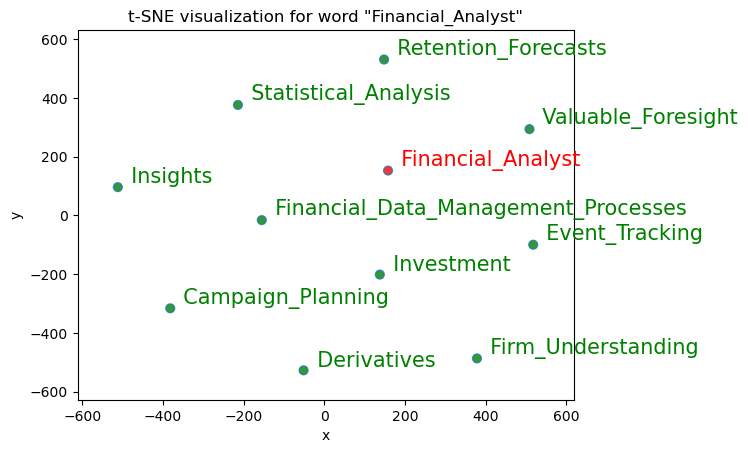

In [41]:
tsne_plot(for_word='financial_analyst', w2v_model=fast_Text_model,n=10)

##### Please feel free to experiment wrt financial analyst dataset

/Users/fission/anaconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/fission/anaconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


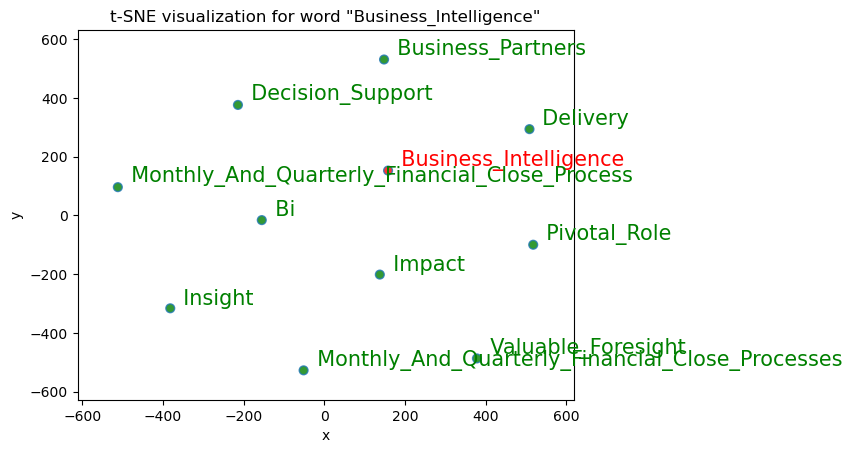

In [42]:
tsne_plot(for_word='business_intelligence', w2v_model=fast_Text_model,n=10)

###### The main core idea behind Word2Vec
<ul>
    <li>Un-supervised clustering</li>
    <li>Training it wrt <b>domain specific data</b> it would try to establish more valuable relationships</li>
    <li>Already you have <b>Glove Vectors</b> which is trained on generic data, please feel free to experiment</li>
</ul>